In [25]:
import tensorflow as tf
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import os
from osgeo import gdal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json
from PIL import Image

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [26]:
batch_size = 5
num_classes = 2
epochs = 5

img_rows, img_cols = 81, 81

array = []
et = []

### Modèle

Chargement du modèle, soit l'ancien non convergent dont la structure est décrite ci-dessous, soit les nouveaux dont la structure est stockée dans des fichiers JSon. A chaque fois les poirds sont stockés dans des fichiers hdf5

In [27]:
def baseline_model():
    model = Sequential()

    model.add(Conv2D(32, (2, 2), input_shape=(81,81,1)))
    model.add(Activation('relu'))
    BatchNormalization(axis=-1)
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (2, 2)))
    model.add(MaxPooling2D(pool_size=(2,2)))
 
 
    BatchNormalization(axis=-1)
    model.add(Conv2D(64,(3, 3)))
    model.add(Activation('relu'))
    BatchNormalization(axis=-1)
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
# 

    model.add(Flatten())
#    # Fully connected layer
#
    BatchNormalization()
    model.add(Dense(512))
    model.add(Activation('relu'))
    BatchNormalization()
    model.add(Dropout(0.5))
    model.add(Dense(2))
    
    sgd = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',#keras.optimizers.Adam(),
              metrics=['accuracy'])
    
    return model

model = baseline_model()
model.load_weights("weights.best946.hdf5")

In [15]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("weights.best6.hdf5")
print("Loaded model from disk")
 

Loaded model from disk


### Chargement données

Chargement des données déjà pré-processées
Possibilité d'appliqer un gradient dessus

In [16]:
x_train = np.load("x.npy")
y_train = np.load("y.npy")
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
y_train = keras.utils.to_categorical(y_train, num_classes)

In [7]:
print(x_train[0].shape)
def gradient(image):
    cha1 = np.gradient(image,axis=(0,1))[1]
    cha2 = np.gradient(image,axis=(0,1))[0]
    return np.sqrt(np.power(cha1, 2) + np.power(cha2, 2))
for i in range(len(x_train)):
    x_train[i] = gradient(x_train[i])

(81, 81, 1)


### Evaluation du modèle

Le modèle prédit les résultats sur les données puis on calculs les différents indicateurs.

On peut aussi tracer l'évolution du rappel et de la précision en fonction du threshold.

Enfin affichage des omage sur lesquelles on a eu des erreurs.

In [20]:
yo_pred = model.predict(x_train)
for i in range(len(yo_pred)):
    if yo_pred[i][0] < yo_pred[i][1]-0.8:
        y_pred[i]=[0,1]
    else:
        y_pred[i]=[1,0]

In [21]:
yy_test = []
yy_pred = []
for i in range(len(y_train)):
    if y_pred[i][0] == 0:
        yy_pred.append(0)
    else:
        yy_pred.append(1)
    
    if y_train[i][0] == 0:
        yy_test.append(0)
    else:
        yy_test.append(1)

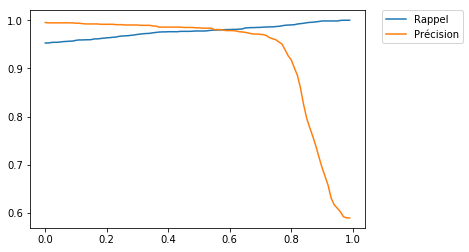

In [22]:
recall_list = []
precision_list = []
k_list = np.arange(0,1,0.01)
for k in k_list:
    for i in range(len(yo_pred)):
        if yo_pred[i][0] < yo_pred[i][1]-k:
            y_pred[i]=[0,1]
        else:
            y_pred[i]=[1,0]
    #edit data    
    yy_test = []
    yy_pred = []
    for i in range(len(y_train)):
        if y_pred[i][0] == 0:
            yy_pred.append(0)
        else:
            yy_pred.append(1)

        if y_train[i][0] == 0:
            yy_test.append(0)
        else:
            yy_test.append(1)
    recall_list.append(recall_score(yy_test,yy_pred))
    precision_list.append(precision_score(yy_test,yy_pred))
    
plt.plot(k_list,recall_list,label='Rappel')
plt.plot(k_list,precision_list,label='Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
        

In [78]:
print(recall_list[90:])
print(precision_list[90:])

[0.99851301115241631, 0.99851301115241631, 0.99851301115241631, 0.99851301115241631, 0.99851301115241631, 0.99851301115241631, 0.99962825278810408, 1.0, 1.0, 1.0]
[0.69477496120020699, 0.67623363544813697, 0.65736661771904059, 0.6305164319248826, 0.6169039963252182, 0.6099000908265213, 0.60250952274254987, 0.59225011008366357, 0.59017112768758229, 0.58991228070175439]


In [23]:
confusion_matrix(yy_test, yy_pred)

array([[   2, 1870],
       [   0, 2690]], dtype=int64)

In [24]:
from sklearn.metrics import recall_score,precision_score,accuracy_score,roc_curve
print("rappel ",recall_score(yy_test,yy_pred))
print("précision ",precision_score(yy_test,yy_pred))
print("accuracy ",accuracy_score(yy_test,yy_pred))
print("Roc curve",roc_curve(yy_test,yy_pred) )

rappel  1.0
précision  0.589912280702
accuracy  0.590092064884
Roc curve (array([ 0.        ,  0.99893162,  1.        ]), array([ 0.,  1.,  1.]), array([2, 1, 0]))


[ 0.10052905  0.89947093]


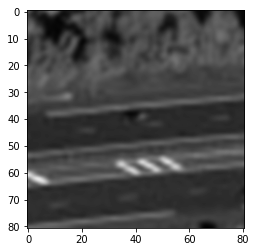

[ 0.11221109  0.88778889]


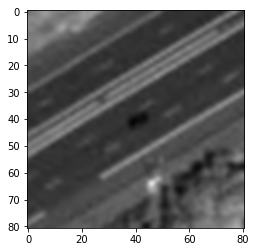

[ 0.07504441  0.92495555]


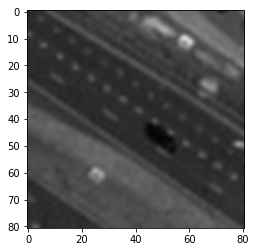

[ 0.07821677  0.92178321]


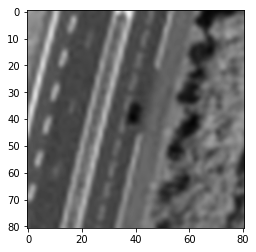

[ 0.08106344  0.91893655]


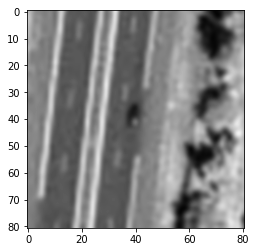

[ 0.05010821  0.94989175]


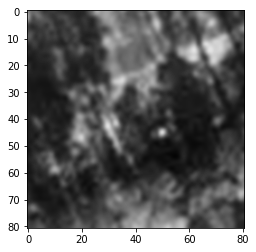

[ 0.13967015  0.86032981]


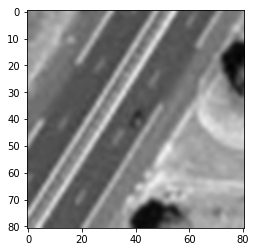

[ 0.12851922  0.87148076]


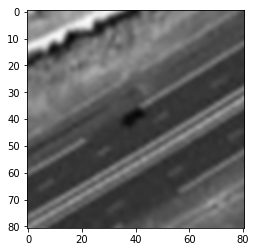

[ 0.08680792  0.91319209]


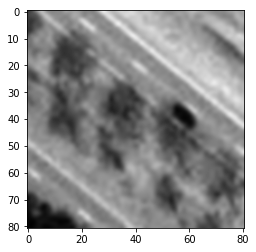

[ 0.11566424  0.88433576]


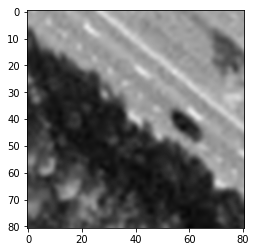

[ 0.11055329  0.88944674]


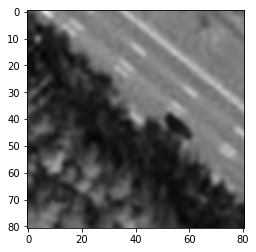

[ 0.0544394   0.94556057]


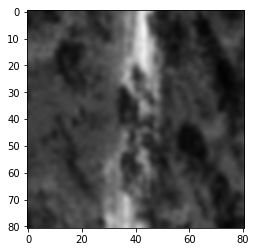

[ 0.11471898  0.88528103]


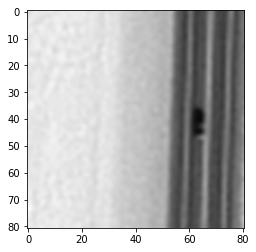

[ 0.10775744  0.89224249]


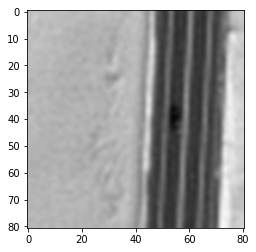

[ 0.09261204  0.90738803]


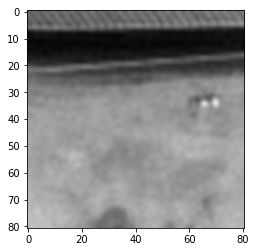

[ 0.08878846  0.91121155]


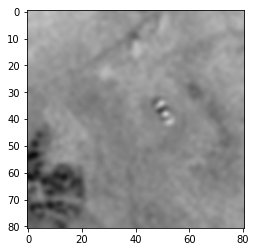

[ 0.09241297  0.90758699]


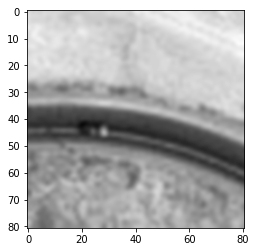

[ 0.09978622  0.90021378]


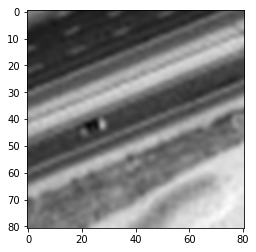

[ 0.09452432  0.90547568]


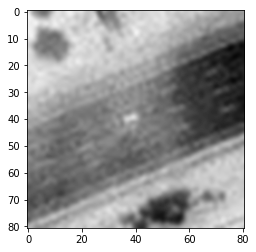

[ 0.12542817  0.87457186]


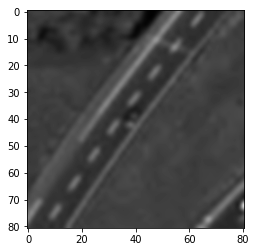

[ 0.06981423  0.93018579]


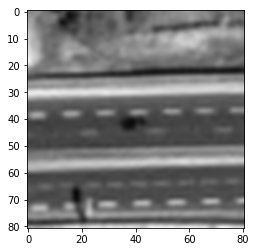

[ 0.06170878  0.93829125]


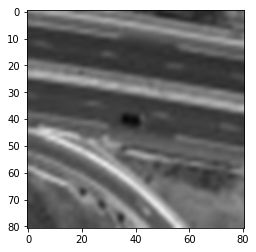

[ 0.11597917  0.88402081]


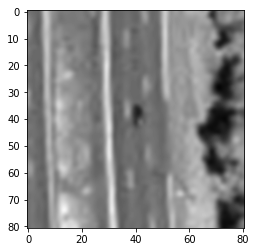

[ 0.14882556  0.85117447]


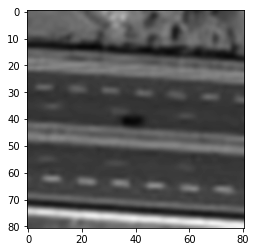

[ 0.14654697  0.85345304]


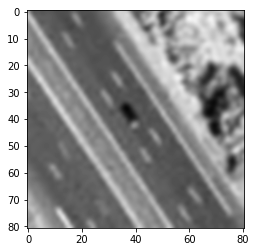

[ 0.12050344  0.87949651]


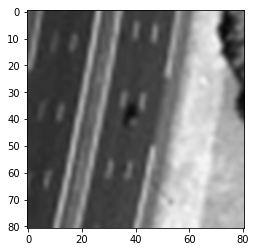

[ 0.11766393  0.88233608]


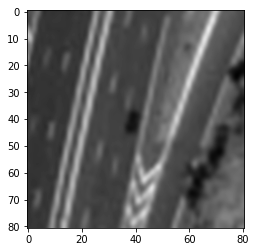

[ 0.08429956  0.91570044]


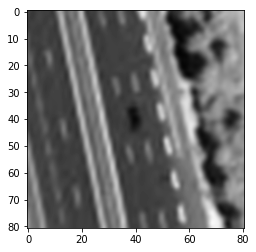

[ 0.05359584  0.9464041 ]


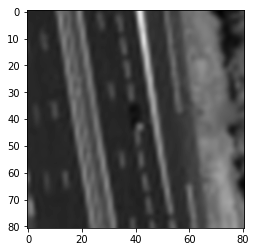

[ 0.07003688  0.92996317]


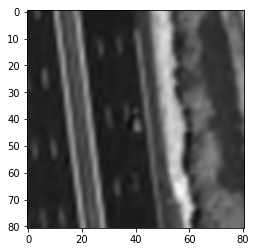

[ 0.02222442  0.97777563]


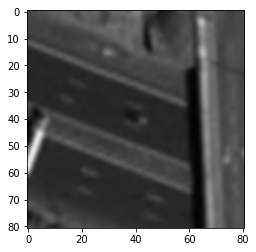

[ 0.07184999  0.92815006]


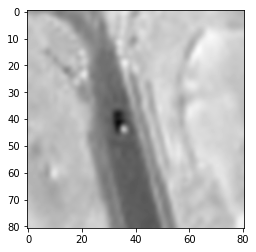

[ 0.02347874  0.97652131]


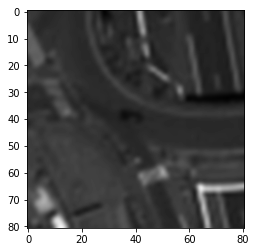

[ 0.01637039  0.98362964]


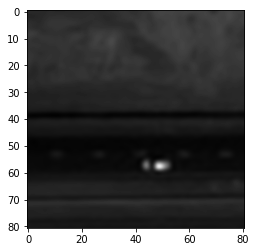

[ 0.05651392  0.94348603]


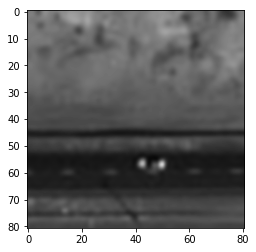

[ 0.02219806  0.97780198]


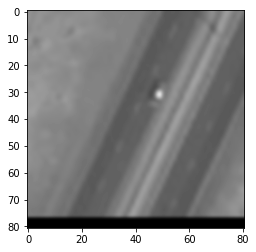

[ 0.05546791  0.94453216]


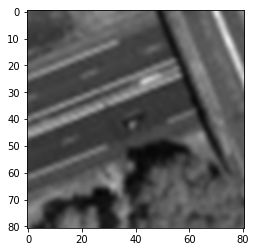

[ 0.07943086  0.92056912]


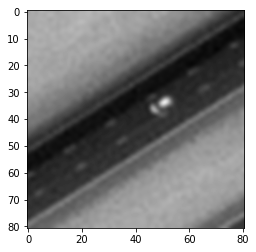

[ 0.09269351  0.90730643]


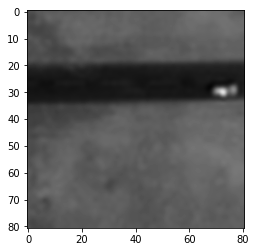

[ 0.06098004  0.93901998]


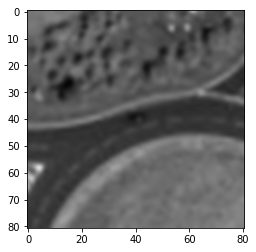

In [60]:
for i in range(len(y_train)):
    if yy_pred[i] != yy_test[i] and yy_pred[i] == 0:
        print(yo_pred[i])
        plt.imshow(x_train[i].reshape((81,81)),cmap='gray',  interpolation='bicubic')
        #print(np.max(x_train[i]))
        plt.show()
        

### Evaluation sur la Corse

On teste les résultats sur la Corse puis on crée une heatmap pour savoir où le réseau détecte les voitures.

In [79]:
from osgeo import gdal
import numpy as np
import os

dataset = gdal.Open('Corse/CORSE_ORTHO.tif', gdal.GA_ReadOnly)

print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                             dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()


if not min or not max:
    (min, max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min, max))


if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

xImgSize = dataset.RasterXSize
yImgSize = dataset.RasterYSize


print(xImgSize,yImgSize)

xActiveWindowSize = 81
yActiveWindowSize = 81
xSuperpositionSize = 0
ySuperpositionSize = 0
xbins = xImgSize//(xActiveWindowSize-xSuperpositionSize)
if xImgSize % (xActiveWindowSize-xSuperpositionSize) != 0:
    xbins += 1
ybins = yImgSize//(yActiveWindowSize-ySuperpositionSize)
if yImgSize % (yActiveWindowSize-ySuperpositionSize) != 0:
    ybins += 1
    
heatmap = np.zeros((yImgSize,xImgSize))
#window = band.ReadAsArray(0, 0, xImgSize,yImgSize)
#plt.imsave('corse.jpg',window)

for i in range(0,xImgSize,xActiveWindowSize-xSuperpositionSize):
    for j in range(0, yImgSize, yActiveWindowSize - ySuperpositionSize):
        xsize = xActiveWindowSize
        if xActiveWindowSize > xImgSize - i:
            xsize = xImgSize - i
        ysize=yActiveWindowSize
        if yActiveWindowSize > yImgSize - j:
            ysize = yImgSize - j
        window = band.ReadAsArray(i, j, xsize, ysize)
        if(window.shape == (81,81)):
            n = model.predict(np.reshape(window, (1,81,81,1)))
            car_size = 15
            if n[0][0] + 0.8 > n[0][1]:#< pas de voiture, > voiture détéctée.
                
                for k in range(i-car_size,i+car_size+1):
                    for l in range(j-car_size,j+car_size+1):
                        heatmap[l][k] = 4296
                #plt.imshow(window,cmap='gray',  interpolation='bicubic')
                #plt.show()
        
        #print("Reading image at offset = ({}, {})".format(i, j))
        #model.predict(window)

        #Window est une fenetre 81*81 qui peut passer dans le nn"""

#plt.imshow(heatmap)
#plt.show()

Driver: GTiff/GeoTIFF
Size is 16704 x 15786 x 1
Projection is PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]
Origin = (0.0, 0.0)
Pixel Size = (1.0, 1.0)
Band Type=UInt16
Min=1.000, Max=4296.000
16704 15786


In [80]:
print(np.count_nonzero(np.fliplr(np.flipud(heatmap))))
cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=heatmap.min(), vmax=heatmap.max())
plt.imsave('testbad.png', cmap(norm(np.fliplr(np.flipud(heatmap)))))

11456081


In [81]:
img = Image.fromarray(heatmap).convert('RGB')
img.save('mygood.jpg')
img.show()

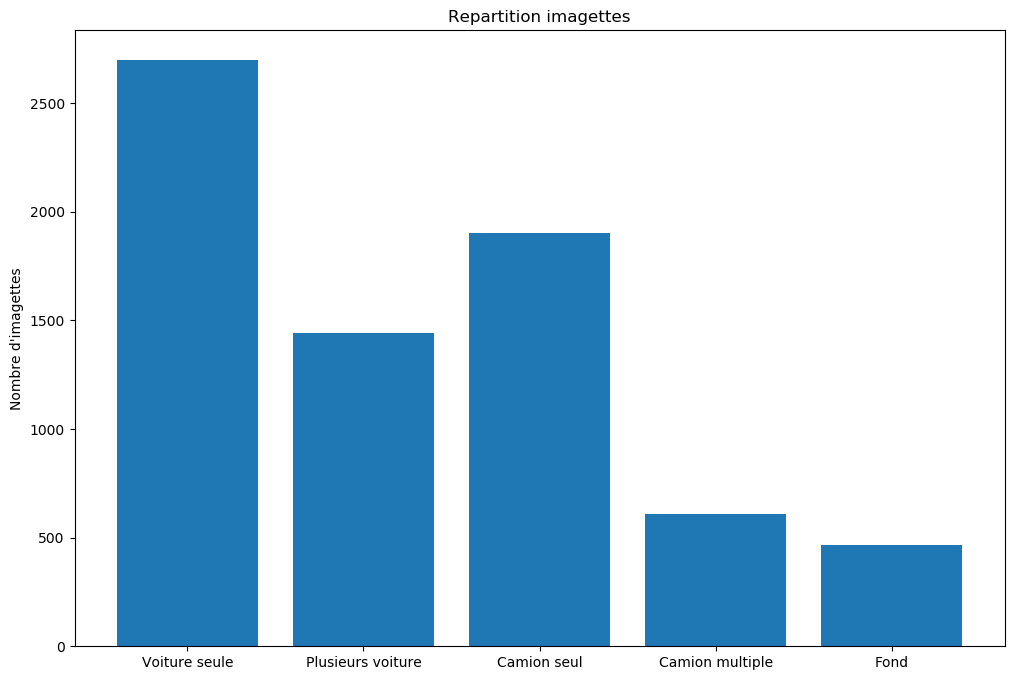

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Voiture seule', 'Plusieurs voiture', 'Camion seul', 'Camion multiple', 'Fond')
y_pos = np.arange(len(objects))
performance = [2700,1440,1900,610,468]
 
plt.figure(figsize=(12, 8))  # width:20, height:3    
plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel("Nombre d'imagettes")
plt.title('Repartition des imagettes')
 
plt.show()

In [28]:
from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, to_file='model_non_conv.png',show_shapes=True)